# Предсказание стоимости жилья

В проекте нам нужно обучить модель линейной регрессии на данных о жилье в Калифорнии в 1990 году. На основе данных нужно предсказать медианную стоимость дома в жилом массиве. Необходимо обучить модель и сделать предсказания на тестовой выборке. Для оценки качества модели нужно использовать метрики RMSE, MAE и R2.

## Загрузка данных и библиотек

Импорт необходимых библиотек

In [1]:
import pandas as pd

import matplotlib.pyplot as plt

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.ml.feature import OneHotEncoder

Инициализация локальной Spark-сессии 

In [2]:
spark = SparkSession.builder \
                    .master('local') \
                    .appName('Housing - Logistic regression') \
                    .getOrCreate()

log4j:ERROR Could not read configuration file from URL [file:/opt/conda/lib/python3.9/site-packages/pyspark/conf/log4j.properties].
java.io.FileNotFoundException: /opt/conda/lib/python3.9/site-packages/pyspark/conf/log4j.properties (Permission denied)
	at java.io.FileInputStream.open0(Native Method)
	at java.io.FileInputStream.open(FileInputStream.java:195)
	at java.io.FileInputStream.<init>(FileInputStream.java:138)
	at java.io.FileInputStream.<init>(FileInputStream.java:93)
	at sun.net.www.protocol.file.FileURLConnection.connect(FileURLConnection.java:90)
	at sun.net.www.protocol.file.FileURLConnection.getInputStream(FileURLConnection.java:188)
	at org.apache.log4j.PropertyConfigurator.doConfigure(PropertyConfigurator.java:557)
	at org.apache.log4j.helpers.OptionConverter.selectAndConfigure(OptionConverter.java:526)
	at org.apache.log4j.LogManager.<clinit>(LogManager.java:127)
	at org.slf4j.impl.Log4jLoggerFactory.<init>(Log4jLoggerFactory.java:66)
	at org.slf4j.impl.StaticLoggerBind

Прочитаем содержимое файла

In [3]:
housing = spark.read.option('header', 'true').csv('/datasets/housing.csv', inferSchema = True) 

## Предобработка и исследовательский анализ данных

Выведем типы данных колонок датасета

In [4]:
housing.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



***Описание данных***

В колонках датасета содержатся следующие данные:
    
* `longitude` — широта;
* `latitude` — долгота;
* `housing_median_age` — медианный возраст жителей жилого массива;
* `total_rooms` — общее количество комнат в домах жилого массива;
* `total_bedrooms` — общее количество спален в домах жилого массива;
* `population` — количество человек, которые проживают в жилом массиве;
* `households` — количество домовладений в жилом массиве;
* `median_income` — медианный доход жителей жилого массива;
* `median_house_value` — медианная стоимость дома в жилом массиве;
* `ocean_proximity` — близость к океану.

In [5]:
housing.show(10)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

Выведем базовые данные описательные статистики данных

In [6]:
housing.describe(housing.columns[:5]).show()

+-------+-------------------+-----------------+------------------+------------------+------------------+
|summary|          longitude|         latitude|housing_median_age|       total_rooms|    total_bedrooms|
+-------+-------------------+-----------------+------------------+------------------+------------------+
|  count|              20640|            20640|             20640|             20640|             20433|
|   mean|-119.56970445736148| 35.6318614341087|28.639486434108527|2635.7630813953488| 537.8705525375618|
| stddev|  2.003531723502584|2.135952397457101| 12.58555761211163|2181.6152515827944|421.38507007403115|
|    min|            -124.35|            32.54|               1.0|               2.0|               1.0|
|    max|            -114.31|            41.95|              52.0|           39320.0|            6445.0|
+-------+-------------------+-----------------+------------------+------------------+------------------+



In [7]:
housing.describe(housing.columns[5:]).show()

+-------+------------------+-----------------+------------------+------------------+---------------+
|summary|        population|       households|     median_income|median_house_value|ocean_proximity|
+-------+------------------+-----------------+------------------+------------------+---------------+
|  count|             20640|            20640|             20640|             20640|          20640|
|   mean|1425.4767441860465|499.5396802325581|3.8706710029070246|206855.81690891474|           null|
| stddev|  1132.46212176534|382.3297528316098| 1.899821717945263|115395.61587441359|           null|
|    min|               3.0|              1.0|            0.4999|           14999.0|      <1H OCEAN|
|    max|           35682.0|           6082.0|           15.0001|          500001.0|     NEAR OCEAN|
+-------+------------------+-----------------+------------------+------------------+---------------+



Исследуем данные на наличие пропусков

In [8]:
for column in housing.columns:
    print(column, housing.filter(F.col(column).isNull()).count())

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 207
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0


* В колонке `total_bedrooms` обнаружили 207 пропусков.

Заменим пропуски в колонке `total_bedrooms`, на произведения коэфициента (средние соотношение спален к общему кол-ву комнат) и кол-во спален

In [9]:
kf = housing.select('total_bedrooms').toPandas()['total_bedrooms'].median() / \
                    housing.select('total_rooms').toPandas()['total_rooms'].median()

In [10]:
housing = housing.withColumn('total_bedrooms', F.when(housing['total_bedrooms'].isNull(), \
                                  housing['total_rooms'] * kf).otherwise(housing['total_bedrooms']))

In [11]:
for column in housing.columns:
    print(column, housing.filter(F.col(column).isNull()).count())

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 0
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0


* Пропуски устранены

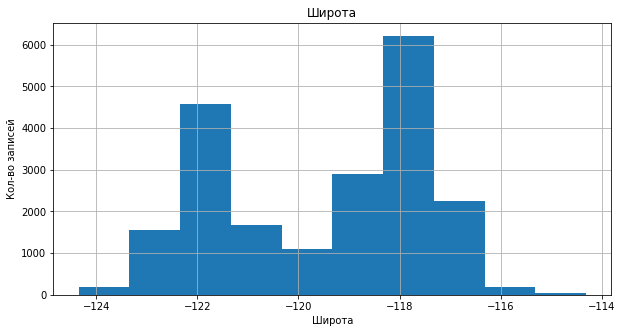

In [12]:
housing.select('longitude').toPandas().hist(figsize=(10, 5), grid=True)
plt.xlabel('Широта')
plt.ylabel('Кол-во записей')
plt.title('Широта')
plt.show() 

* Значения корректные

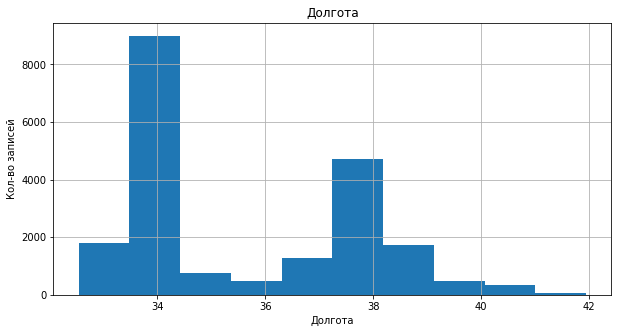

In [13]:
housing.select('latitude').toPandas().hist(figsize=(10, 5), grid=True)
plt.xlabel('Долгота')
plt.ylabel('Кол-во записей')
plt.title('Долгота')
plt.show() 

* Значения корректные

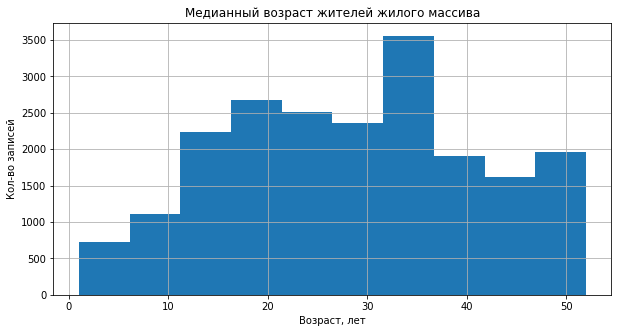

In [14]:
housing.select('housing_median_age').toPandas().hist(figsize=(10, 5), grid=True)
plt.xlabel('Возраст, лет')
plt.ylabel('Кол-во записей')
plt.title('Медианный возраст жителей жилого массива')
plt.show() 

* Значения корректные

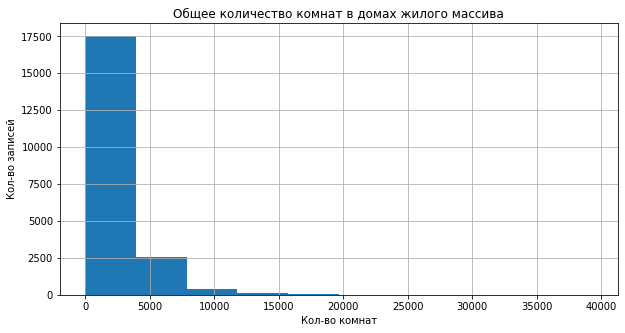

In [15]:
housing.select('total_rooms').toPandas().hist(figsize=(10, 5), grid=True)
plt.xlabel('Кол-во комнат')
plt.ylabel('Кол-во записей')
plt.title('Общее количество комнат в домах жилого массива')
plt.show() 

* Значения корректные

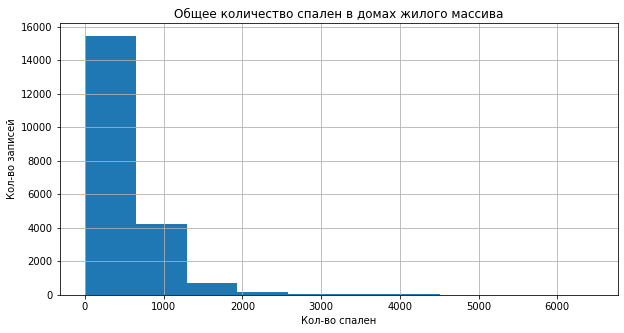

In [16]:
housing.select('total_bedrooms').toPandas().hist(figsize=(10, 5), grid=True)
plt.xlabel('Кол-во спален')
plt.ylabel('Кол-во записей')
plt.title('Общее количество спален в домах жилого массива')
plt.show() 

* Значения корректные

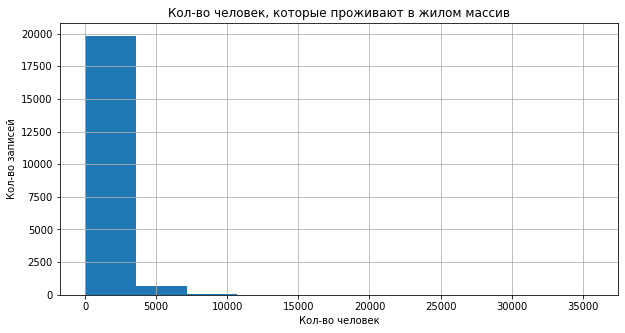

In [17]:
housing.select('population').toPandas().hist(figsize=(10, 5), grid=True)
plt.xlabel('Кол-во человек')
plt.ylabel('Кол-во записей')
plt.title('Кол-во человек, которые проживают в жилом массив') 
plt.show() 

* Значения корректные

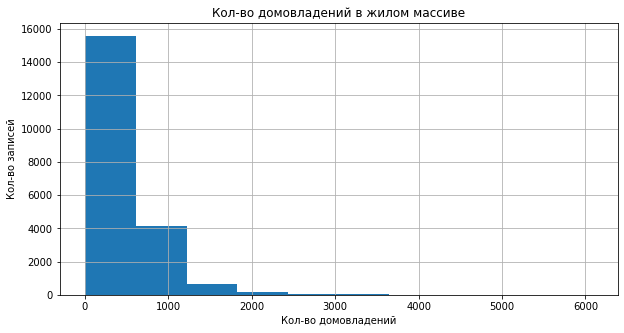

In [18]:
housing.select('households').toPandas().hist(figsize=(10, 5), grid=True)
plt.xlabel('Кол-во домовладений')
plt.ylabel('Кол-во записей')
plt.title('Кол-во домовладений в жилом массиве')
plt.show() 

* Значения корректные

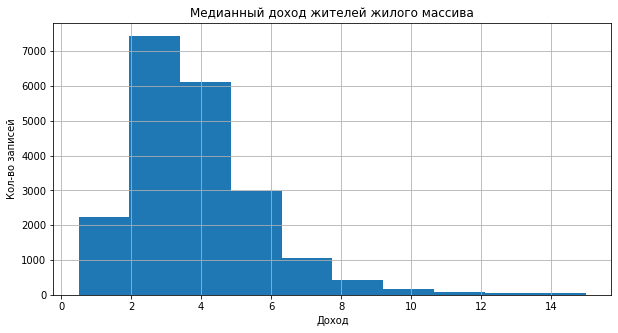

In [19]:
housing.select('median_income').toPandas().hist(figsize=(10, 5), grid=True)
plt.xlabel('Доход')
plt.ylabel('Кол-во записей')
plt.title('Медианный доход жителей жилого массива')
plt.show() 

* Значения корректные

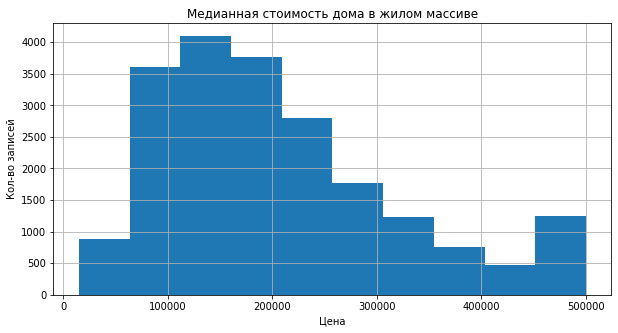

In [20]:
housing.select('median_house_value').toPandas().hist(figsize=(10, 5), grid=True)
plt.xlabel('Цена')
plt.ylabel('Кол-во записей')
plt.title('Медианная стоимость дома в жилом массиве')
plt.show() 

* Значения корректные

In [21]:
housing.select('ocean_proximity').toPandas().value_counts()

ocean_proximity
<1H OCEAN          9136
INLAND             6551
NEAR OCEAN         2658
NEAR BAY           2290
ISLAND                5
dtype: int64

* Значения корректные

## Подготовка признаков и выборок

Создадим списки с числовыми признаками и таргетом

In [22]:
numerical_cols  = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
                   'total_bedrooms', 'population', 'households', 'median_income']
target = 'median_house_value' 

### Подготовка категориальных признаков

Трансформируем категориальные признаки с помощью трансформера StringIndexer

In [23]:
indexer = StringIndexer(inputCol='ocean_proximity', 
                        outputCol='ocean_proximity_idx') 
housing = indexer.fit(housing).transform(housing)

Трансформируем категориальные признаки с помощью OHE-кодирования

In [24]:
encoder = OneHotEncoder(inputCol='ocean_proximity_idx',
                        outputCol='ocean_proximity_ohe')
housing  = encoder.fit(housing ).transform(housing)

### Подготовка числовых признаков

Объеденим все числовые признаки в один столбец

In [25]:
numerical_assembler = VectorAssembler(inputCols=numerical_cols,
                                      outputCol='numerical_features')
housing = numerical_assembler.transform(housing)

Произведем шкалирование столбца с числовыми признаками

In [26]:
standardScaler = StandardScaler(inputCol='numerical_features', 
                                outputCol='numerical_features_scaled')
housing = standardScaler.fit(housing).transform(housing)

Объеденим все признаки в один столбец

In [27]:
all_features = ['ocean_proximity_ohe','numerical_features_scaled']
final_assembler = VectorAssembler(inputCols=all_features, 
                                  outputCol='features') 
housing = final_assembler.transform(housing)

* Данные подготовлены, можно приступать к обучению модели

Разделим наш датасет на две части — выборку для обучения и выборку для тестирования качества модели.

In [28]:
train_data, test_data = housing.randomSplit([.75,.25], seed=12345)
print(train_data.count(), test_data.count()) 

15406 5234


## Обучение моделей

### Выборка со всеми признаками

Обучим модель

In [29]:
lr_all = LinearRegression(labelCol=target, featuresCol='features')
modelEvaluator=RegressionEvaluator(predictionCol="prediction", labelCol=target, metricName="r2")
paramGrid = ParamGridBuilder().addGrid(lr_all.regParam, [0.1, 0.01]) \
                              .addGrid(lr_all.elasticNetParam, [0, 1]).build()
crossval = CrossValidator(estimator=lr_all,
                          estimatorParamMaps=paramGrid,
                          evaluator=modelEvaluator,
                          numFolds=3)
cvModel_all = crossval.fit(train_data)

22/06/03 10:49:05 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/06/03 10:49:05 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
22/06/03 10:49:05 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
22/06/03 10:49:05 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


Создадим функцию для вывода и записи оценок качества моделей

In [30]:
def estimation (model_results, name, write):
    
    RMSE = round(model_results.rootMeanSquaredError, 2)
    r2 = round(model_results.r2, 4)
    MAE = round(model_results.meanAbsoluteError, 2)
    
    print(f'RMSE: {RMSE}')
    print(f'r2: {r2}')
    print(f'MAE: {MAE}')
    
    global table_estimation
    if write:
        table_estimation = table_estimation.append({'Name':name, 'RMSE':RMSE,
         'r2':r2,'MAE':MAE}, ignore_index=True)

Оценим качество модели на тренировочной выборке

In [31]:
estimation(cvModel_all.bestModel.summary, 'All signs', False)

RMSE: 69150.55
r2: 0.6399
MAE: 50149.97


Создадим пустую сводную таблицу для оценок моделей

In [32]:
table_estimation = pd.DataFrame(columns=['Name', 'RMSE', 'r2', 'MAE'])

Оценим качество модели на тестовой выборке

In [33]:
test_result = cvModel_all.bestModel.evaluate(test_data)

In [34]:
estimation(test_result, 'All signs', True)

RMSE: 67139.77
r2: 0.6641
MAE: 48938.39


### Выборка с числовыми признаками

Обучим модель

In [35]:
lr_numbers = LinearRegression(labelCol=target, featuresCol='numerical_features_scaled')
modelEvaluator=RegressionEvaluator(predictionCol="prediction", labelCol=target, metricName="r2")
paramGrid = ParamGridBuilder().addGrid(lr_numbers.regParam, [0.1, 0.01]) \
                              .addGrid(lr_numbers.elasticNetParam, [0, 1]).build()
crossval = CrossValidator(estimator=lr_numbers,
                          estimatorParamMaps=paramGrid,
                          evaluator=modelEvaluator,
                          numFolds=3)
cvModel_numbers = crossval.fit(train_data)

Оценим качество модели на тренировочной выборке

In [36]:
estimation(cvModel_numbers.bestModel.summary, 'numbers signs', False)

RMSE: 70036.37
r2: 0.6306
MAE: 51195.97


Оценим качество модели на тестовой выборке

In [37]:
test_result = cvModel_numbers.bestModel.evaluate(test_data)

In [38]:
estimation(test_result, 'numbers signs', True)

RMSE: 68177.09
r2: 0.6536
MAE: 50103.21


## Анализ результатов

In [39]:
table_estimation

,Name,RMSE,r2,MAE
0,All signs,67139.77,0.6641,48938.39
1,numbers signs,68177.09,0.6536,50103.21


* Удаление категориальных признаков приводит к ухудшению качества модели;
* Использование всех признаков является оптимальным вариантом в нашем случае.